In [1]:
import keras
import numpy as np
import pandas as pd

# Image Loading
from imageio import imread
import cv2 # for image processing to Black and white 1 channel

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
class ModelParameters:

    def __init__(self,
                 training_data_path,
                 num_classes=28,
                 num_epochs=5,
                 batch_size=16,
                 image_rows=1708,
                 image_cols=1708,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 n_channels=3,
                 using_imagenet=False,
                 shuffle=False):
        
        self.training_data_path = training_data_path
        self.num_classes = num_classes
        # what does n_epochs mean? it seems we pass this into the "epochs"
        # parameter on the "fit_generator" method on our keras model
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.row_dimension = np.int(image_rows / row_scale_factor)
        self.col_dimension = np.int(image_cols / col_scale_factor)
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        if using_imagenet:
            self.row_dimension = 224
            self.col_dimension = 224
            self.n_channels = 3

In [4]:
class ImagePreprocessor:

    def __init__(self, modelParameters):
        self.image_path = modelParameters.training_data_path
        self.n_channels = modelParameters.n_channels
        self.row_dimension = modelParameters.row_dimension
        self.col_dimension = modelParameters.col_dimension

    def preprocess(self, image):
        image = cv2.resize(image, (self.row_dimension, self.col_dimension))
        # image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        image /= 255
        return image

    def load_image(self, image_id):
        image = cv2.imread(self.image_path + image_id + '.jpg')
        if self.n_channels == 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert Color to Greyscalle (1 channel)
            np_image = np.zeros(shape=(image.shape[0], image.shape[1]))
        else:
            np_image = np.zeros(shape=(image.shape[0], image.shape[1], self.n_channels))
        np_image[:,:] = image
        return np_image

In [5]:
# test image loader

image = cv2.imread("./lesion_images/all_images_processed/" + "0001-1" + '.jpg')
image = cv2.resize(image, (224, 224))
image = np.reshape(image, (image.shape[0], image.shape[1], 3))
image.shape

(224, 224, 3)

In [43]:
class ImageBatchGenerator(keras.utils.Sequence):
    
    def __init__(self, image_ids, dataframe, model_params, image_processor):
        '''
        Writing a child implementation of keras.utils.Sequence will help us
        manage our batches of data.
        Each sequence must implement __len__ and __getitem__
        This structure guarantees that the network will only train once on each
        sample per epoch which is not the case with generators.
        
        We can use this class to instantiate training and validation generators
        that we can pass into our keras model like:
        
        training_generator = ImageBatchLoader(...)
        validation_generator = ImageBatchLoader(...)
        model.set_generators(training_generator, validation_generator)
        '''
        self.image_ids = image_ids
        self.dataframe = dataframe

        # Helper classes
        self._imageProcessor = image_processor

        # Training parameters
        self.batch_size = model_params.batch_size
        self.dimensions = (model_params.row_dimension, model_params.col_dimension)
        self.n_channels = model_params.n_channels
        self.shuffle = model_params.shuffle

        # Run on_epoch_end in _init_ to init our first image batch
        self.on_epoch_end()
        
    def on_epoch_end(self):
        '''
        Tensorflow will run this method at the end of each epoch
        So this is where we will modify our batch.
        '''
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        # Denotes the number of batchs per epoch
        return int(np.floor(len(self.image_ids) / self.batch_size))
            
    def __getitem__(self, index):
        # Get this batches indexes
        indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]

        # Get cooresponding image Ids
        batch_image_ids = [self.image_ids[i] for i in indexes]

        # Generate one batch of data
        X, y = self.__generator(batch_image_ids)
        return X, y
    
    def __generator(self, batch_image_ids):

        def get_target_class(imageid):
            # .loc will lookup the row where the passed in statement is true
            target = self.dataframe.loc[self.dataframe.imageId == imageid]
            target = target.lesion.values[0]
            return target

        X = np.empty((self.batch_size, *self.dimensions, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for index, imageid in enumerate(batch_image_ids):
            image = self._imageProcessor.load_image(imageid)
            image = self._imageProcessor.preprocess(image)

            X[index] = image
            y[index] = get_target_class(imageid)

        return X, y

In [44]:
# Predict Generator
class PredictGenerator:

    def __init__(self, image_ids, image_processor, image_path):
        self.image_processor = image_processor
        self.image_processor.image_path = image_path
        self.image_ids = image_ids

    def predict(self, model):
        y = np.empty(shape=(len(self.image_ids)))
        for n in range(len(self.image_ids)):
            image = self.image_processor.load_image(self.image_ids[n])
            image = self.image_processor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        return y

In [45]:
# Build the baseline model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta
from keras.models import load_model, Model
from keras.applications import DenseNet121

class BaselineModel:
    
    def __init__(self, model_params):
        self.img_rows = model_params.row_dimension
        self.img_cols = model_params.col_dimension
        self.n_channels = model_params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.num_epochs = model_params.num_epochs
        self.metrics = ['accuracy']
        
    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        self.model.add(Conv2D(32, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def build_resnet(self):
        base_model = DenseNet121(
            include_top=False, 
            weights='imagenet')
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
        x = Dense(1024,activation='relu')(x) #dense layer 2
        x = Dense(512,activation='relu')(x) #dense layer 3
        preds = Dense(1,activation='sigmoid')(x) #final layer with softmax activation
        
        self.model = Model(inputs=base_model.input, outputs=preds)
        
#         for layer in self.model.layers[:20]:
#             layer.trainable=False
#         for layer in self.model.layers[20:]:
#             layer.trainable=True

        
    def compile_model(self):
        sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=self.metrics)
        
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator

    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.num_epochs,
                    use_multiprocessing=True,
                    workers=8,
                    verbose=1)

    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=True,
                                      workers=8)

    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y

    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)

    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

In [46]:
data = pd.read_csv("./lesion-csv.csv")
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# All we care about at this point is the id and class
train_df = train_df.drop(
    ["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)

test_df = test_df.drop(
    ["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)

print(train_df.head())
print(test_df.head())

  imageId  lesion
0  0074-0       1
1  0074-1       1
2  0074-2       1
3  0074-3       1
4  0141-0       1
  imageId  lesion
0  0317-0       0
1  0317-1       0
2  0317-2       0
3  0317-3       0
4  0129-0       1


In [47]:
# k-fold cross-validation
# from sklearn.model_selection import RepeatedKFold

# splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

# partitions = []

# for train_idx, test_idx in splitter.split(dataframe.index.values):
#     partition = {}
#     partition["train"] = dataframe.imageId.values[train_idx]
#     partition["validation"] = dataframe.imageId.values[test_idx]
#     partitions.append(partition)

partition = {
    "train": train_df.imageId.values,
    "validation": test_df.imageId.values,
}

In [48]:
imageid = partition["train"][0]

print(imageid)

target = data.loc[data.imageId == imageid]

print(target)

# target = data.drop(["imageId"], axis=1).values[0][0]
target = target.lesion.values[0]

print(target)

0074-0
   Unnamed: 0 imageId teethNumbers         description numberOfCanals  \
0           0  0074-0           46  ReTx,PTGP,3Cshaped            NaN   

         date sequenceNumber  lesion  
0  2018-08-14             f1       1  
1


In [54]:
train_path = './lesion_images/all_images_processed/'

model_params = ModelParameters(
    train_path,
    num_epochs=10,
    batch_size=16,
    image_rows=224,
    image_cols=224,
    row_scale_factor=1,
    col_scale_factor=1)

image_processor = ImagePreprocessor(model_params)


training_generator = ImageBatchGenerator(partition['train'], data, model_params, image_processor)
validation_generator = ImageBatchGenerator(partition['validation'], data, model_params, image_processor)
predict_generator = PredictGenerator(partition['validation'], image_processor, train_path)

In [55]:
X, y = training_generator.__getitem__(1)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [56]:
model = BaselineModel(model_params)
model.build_resnet()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
# model.save("baseline_model.h5")

Epoch 1/10
70/70 [==============================] - 72s 1s/step - loss: 0.2601 - acc: 0.5491 - val_loss: 0.2423 - val_acc: 0.5844
Epoch 2/10
70/70 [==============================] - 53s 754ms/step - loss: 0.2196 - acc: 0.6670 - val_loss: 0.2528 - val_acc: 0.4875
Epoch 3/10
70/70 [==============================] - 52s 736ms/step - loss: 0.1647 - acc: 0.8054 - val_loss: 0.2856 - val_acc: 0.4969
Epoch 4/10
70/70 [==============================] - 53s 762ms/step - loss: 0.1027 - acc: 0.9071 - val_loss: 0.2886 - val_acc: 0.5219
Epoch 5/10
70/70 [==============================] - 52s 741ms/step - loss: 0.0590 - acc: 0.9527 - val_loss: 0.2310 - val_acc: 0.6469
Epoch 6/10
70/70 [==============================] - 52s 744ms/step - loss: 0.0300 - acc: 0.9884 - val_loss: 0.2599 - val_acc: 0.5781
Epoch 7/10
70/70 [==============================] - 53s 752ms/step - loss: 0.0241 - acc: 0.9830 - val_loss: 0.2290 - val_acc: 0.6813
Epoch 8/10
70/70 [==============================] - 52s 750ms/step - los

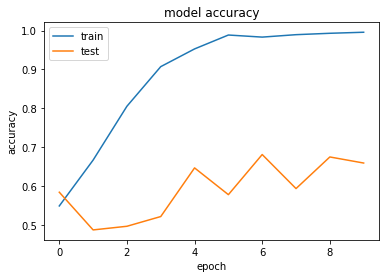

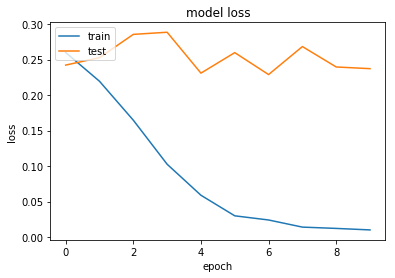

In [57]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
probability_predictions = model.predict(predict_generator)

In [16]:
baseline_probability_predictions = pd.DataFrame(probability_predictions, columns=["lesion", "imageId"])
baseline_probability_predictions.to_csv("baseline_predictions.csv")

ValueError: Shape of passed values is (332, 1), indices imply (332, 2)